In [1]:
%matplotlib inline

# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()

import importlib
from libs import params, trades, feats, plots, models_core, models_custom
importlib.reload(params)
importlib.reload(trades)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)
importlib.reload(models_custom)

<module 'libs.models_custom' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_custom.py'>

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy  as np
import math
import matplotlib.pyplot as plt

import datetime as dt
import os
from typing import Sequence, List, Tuple, Optional, Union

import torch.nn as nn
from torch.nn import MSELoss, Dropout
import torch.nn.functional as Funct
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau, OneCycleLR
from torch.amp import GradScaler

from tqdm import tqdm

In [3]:
df_feat_sel = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[params.features_cols_tick + ['close_raw'] + [params.label_col]]
    
df_feat_sel

,adx,adx_30,adx_60,adx_90,eng_ma,dow_time,hour_time,minute_time,in_sess_time,mom_sum_30,mom_sum_60,mom_sum_90,macd_diff_z_30,macd_diff_z_60,macd_diff_z_90,eng_macd,bb_w_z_30,bb_w_z_60,bb_w_z_90,close_raw,signal
2009-01-02 11:02:00,0.000000,0.000000,0.000000,0.000000,0.502857,0.000000,0.0,0.000000,0.0,0.502028,0.505152,0.501441,0.500000,0.500000,0.500000,0.493704,0.500000,0.500000,0.500000,3.069643,4.056946e-07
2009-01-02 11:03:00,0.000000,0.000000,0.000000,0.000000,0.502857,0.000000,0.0,0.001672,0.0,0.502028,0.505152,0.501441,0.500000,0.500000,0.500000,0.493704,0.500000,0.500000,0.500000,3.069643,4.336628e-07
2009-01-02 11:04:00,0.000000,0.000000,0.000000,0.000000,0.502857,0.000000,0.0,0.003345,0.0,0.502028,0.505152,0.501441,0.500000,0.500000,0.500000,0.493704,0.500000,0.500000,0.500000,3.069643,4.635591e-07
2009-01-02 11:05:00,0.000000,0.000000,0.000000,0.000000,0.502857,0.000000,0.0,0.005017,0.0,0.502028,0.505152,0.501441,0.500000,0.500000,0.500000,0.493704,0.500000,0.500000,0.500000,3.069643,4.955165e-07
2009-01-02 11:06:00,0.000000,0.000000,0.000000,0.000000,0.502857,0.000000,0.0,0.006689,0.0,0.502028,0.505152,0.501441,0.500000,0.500000,0.500000,0.493704,0.500000,0.500000,0.500000,3.069643,5.296769e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.301944,0.142115,0.097797,0.086120,0.586764,0.833333,0.9,0.993311,1.0,0.593685,0.489164,0.461745,0.536610,0.523874,0.520892,0.585090,0.511353,0.499509,0.501419,196.815000,1.654708e-01
2025-06-18 20:57:00,0.328685,0.151717,0.099996,0.086780,0.584584,0.833333,0.9,0.994983,1.0,0.596077,0.494380,0.463351,0.529268,0.518801,0.517021,0.573551,0.517347,0.503922,0.506037,196.675000,1.484384e-01
2025-06-18 20:58:00,0.353515,0.160999,0.102159,0.087434,0.582494,0.833333,0.9,0.996655,1.0,0.599769,0.499956,0.465242,0.519803,0.513143,0.512273,0.558519,0.522203,0.508275,0.510141,196.670000,1.477119e-01
2025-06-18 20:59:00,0.348960,0.163913,0.102810,0.087420,0.580069,0.833333,0.9,0.998328,1.0,0.601615,0.504316,0.466345,0.483053,0.482705,0.483070,0.481714,0.521858,0.508983,0.510762,196.240000,1.166764e-01


In [4]:
train_loader, val_loader, test_loader, end_times_tr, end_times_val, end_times_te = models_core.model_core_pipeline(
    df             = df_feat_sel,
    look_back      = params.hparams["LOOK_BACK"],
    sess_start     = params.sess_start_pred_tick,
    train_prop     = params.train_prop,
    val_prop       = params.val_prop,
    train_batch    = params.hparams["TRAIN_BATCH"],
    train_workers  = params.hparams["TRAIN_WORKERS"],
    prefetch_factor= params.hparams["TRAIN_PREFETCH_FACTOR"],
    signal_thresh  = params.best_optuna_params["buy_threshold"],
    return_thresh  = params.return_threshold_tick
)

Preparing days:   0%|          | 0/4141 [00:00<?, ?it/s]

N_total: 1867591 look_back: 60 F: 19
Estimated X_buf size: 8.52 GB — using RAM (in-memory) (thresh 36 GiB)


Writing days:   0%|          | 0/4141 [00:00<?, ?it/s]

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

In [5]:
for name, ld, tm in zip(
    ["train","val","test"],
    [train_loader, val_loader, test_loader],
    [end_times_tr, end_times_val, end_times_te]
):
    models_core.summarize_split(name, ld, tm)


--- TRAIN ---
 calendar days : 2912  (2009-01-02 → 2020-07-28)
 windows       : 1313312  (per-day min=451, max=451, mean=451.0)
 window shape  : look_back=60, n_features=19
 dataloader    : batches=182, batch_size=16, workers=8, pin_memory=True
 baselines     : baseline prediction=0.087181, baseline RMSE = 0.0997306

--- VAL ---
 calendar days : 608  (2020-07-29 → 2022-12-23)
 windows       : 274208  (per-day min=451, max=451, mean=451.0)
 window shape  : look_back=60, n_features=19
 dataloader    : batches=608, batch_size=1, workers=0, pin_memory=True
 baselines     : baseline prediction=0.104322, baseline RMSE = 0.109576

--- TEST ---
 calendar days : 621  (2022-12-27 → 2025-06-18)
 windows       : 280071  (per-day min=451, max=451, mean=451.0)
 window shape  : look_back=60, n_features=19
 dataloader    : batches=621, batch_size=1, workers=0, pin_memory=True
 baselines     : baseline prediction=0.0891648, baseline RMSE = 0.0983908



In [6]:
# importlib.reload(models_custom) #############

model = models_custom.ModelClass(
    n_feats             = len(params.features_cols_tick),
    short_units         = params.hparams["SHORT_UNITS"],
    long_units          = params.hparams["LONG_UNITS"],
    transformer_d_model = params.hparams["TRANSFORMER_D_MODEL"],
    transformer_layers  = params.hparams["TRANSFORMER_LAYERS"],
    dropout_short       = params.hparams["DROPOUT_SHORT"],
    dropout_long        = params.hparams["DROPOUT_LONG"],
    dropout_trans       = params.hparams["DROPOUT_TRANS"],
    pred_hidden         = params.hparams["PRED_HIDDEN"],
    look_back           = params.hparams["LOOK_BACK"],

    # Gating flags
    use_conv            = params.hparams["USE_CONV"],
    use_tcn             = params.hparams["USE_TCN"],
    use_short_lstm      = params.hparams["USE_SHORT_LSTM"],
    use_transformer     = params.hparams["USE_TRANSFORMER"],
    use_long_lstm       = params.hparams["USE_LONG_LSTM"],
    use_delta           = params.hparams["USE_DELTA"],
    flatten_mode        = params.hparams["FLATTEN_MODE"]
)

model.feature_names = params.features_cols_tick # for logging
model.to(params.device)  
    
model

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:375: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


ModelClass(
  (conv): Identity()
  (bn): Identity()
  (relu): ReLU()
  (tcn): Identity()
  (ln_short): Identity()
  (do_short): Identity()
  (input_proj): Linear(in_features=19, out_features=19, bias=True)
  (feature_proj): Linear(in_features=19, out_features=128, bias=True)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
 

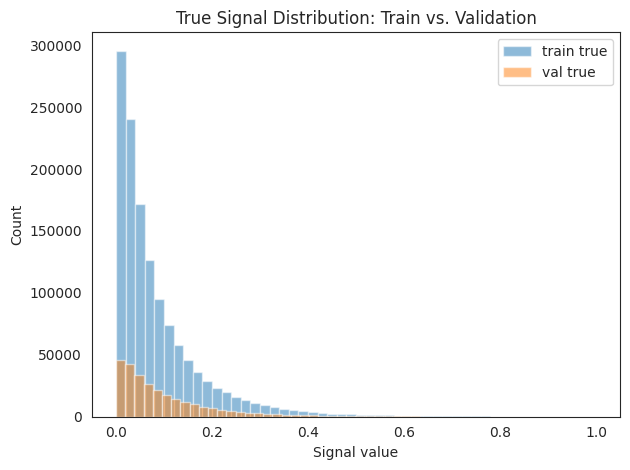

In [7]:
y_train = np.concatenate([batch[1].cpu().numpy().ravel() for batch in train_loader])
y_val = np.concatenate([batch[1].cpu().numpy().ravel() for batch in val_loader])

# Visualize the true‐signal distributions on train vs. validation
plt.hist(y_train, bins=50, alpha=0.5, label="train true")
plt.hist(y_val,   bins=50, alpha=0.5, label="val true")
plt.xlabel("Signal value")
plt.ylabel("Count")
plt.title("True Signal Distribution: Train vs. Validation")
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
optimizer = AdamW(
  model.parameters(),
  lr           = params.hparams["ONECYCLE_MAX_LR"],
  weight_decay = params.hparams["WEIGHT_DECAY"]
)

batches_per_epoch = len(train_loader)
total_steps = batches_per_epoch * params.hparams["MAX_EPOCHS"]

scheduler = OneCycleLR(
  optimizer,
  max_lr           = params.hparams["ONECYCLE_MAX_LR"],
  total_steps      = total_steps,
  pct_start        = params.hparams["ONECYCLE_PCT_START"],
  div_factor       = params.hparams["ONECYCLE_DIV_FACTOR"],
  final_div_factor = params.hparams["ONECYCLE_FINAL_DIV"],
  anneal_strategy  = params.hparams["ONECYCLE_STRATEGY"],
)
optimizer.scheduler = scheduler # necessary to log sched_field

if getattr(scheduler, "total_steps", None) != total_steps:
    raise RuntimeError(f"Scheduler total_steps mismatch: scheduler={getattr(scheduler,'total_steps',None)} expected={total_steps}")

Training sees 2912 unique trading days per epoch.

Model parameters: total=417,024, trainable=417,024

Using HyperParameters:
 {'USE_CONV': False, 'CONV_K': 3, 'CONV_DILATION': 1, 'CONV_CHANNELS': 64, 'USE_TCN': False, 'TCN_LAYERS': 3, 'TCN_KERNEL': 3, 'TCN_CHANNELS': 64, 'USE_SHORT_LSTM': False, 'SHORT_UNITS': 96, 'DROPOUT_SHORT': 0.2, 'USE_TRANSFORMER': True, 'TRANSFORMER_D_MODEL': 128, 'TRANSFORMER_LAYERS': 2, 'TRANSFORMER_HEADS': 4, 'TRANSFORMER_FF_MULT': 4, 'DROPOUT_TRANS': 0.2, 'USE_LONG_LSTM': False, 'DROPOUT_LONG': 0.2, 'LONG_UNITS': 128, 'FLATTEN_MODE': 'attn', 'PRED_HIDDEN': 128, 'ALPHA_SMOOTH': 0.0, 'WARMUP_STEPS': 5, 'USE_HUBER': False, 'HUBER_DELTA': 0.1, 'USE_DELTA': True, 'LAMBDA_DELTA': 0.1, 'MAX_EPOCHS': 90, 'EARLY_STOP_PATIENCE': 9, 'WEIGHT_DECAY': 0.0001, 'CLIPNORM': 1, 'ONECYCLE_MAX_LR': 0.001, 'ONECYCLE_DIV_FACTOR': 10, 'ONECYCLE_FINAL_DIV': 100, 'ONECYCLE_PCT_START': 0.1, 'ONECYCLE_STRATEGY': 'cos', 'TRAIN_BATCH': 16, 'VAL_BATCH': 1, 'TRAIN_WORKERS': 8, 'TRAIN_PRE

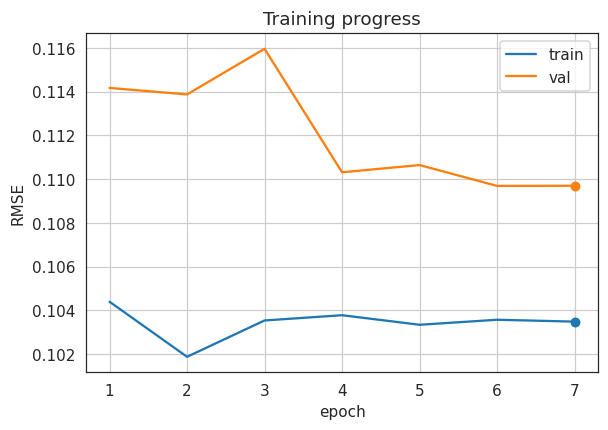

Epoch 1 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

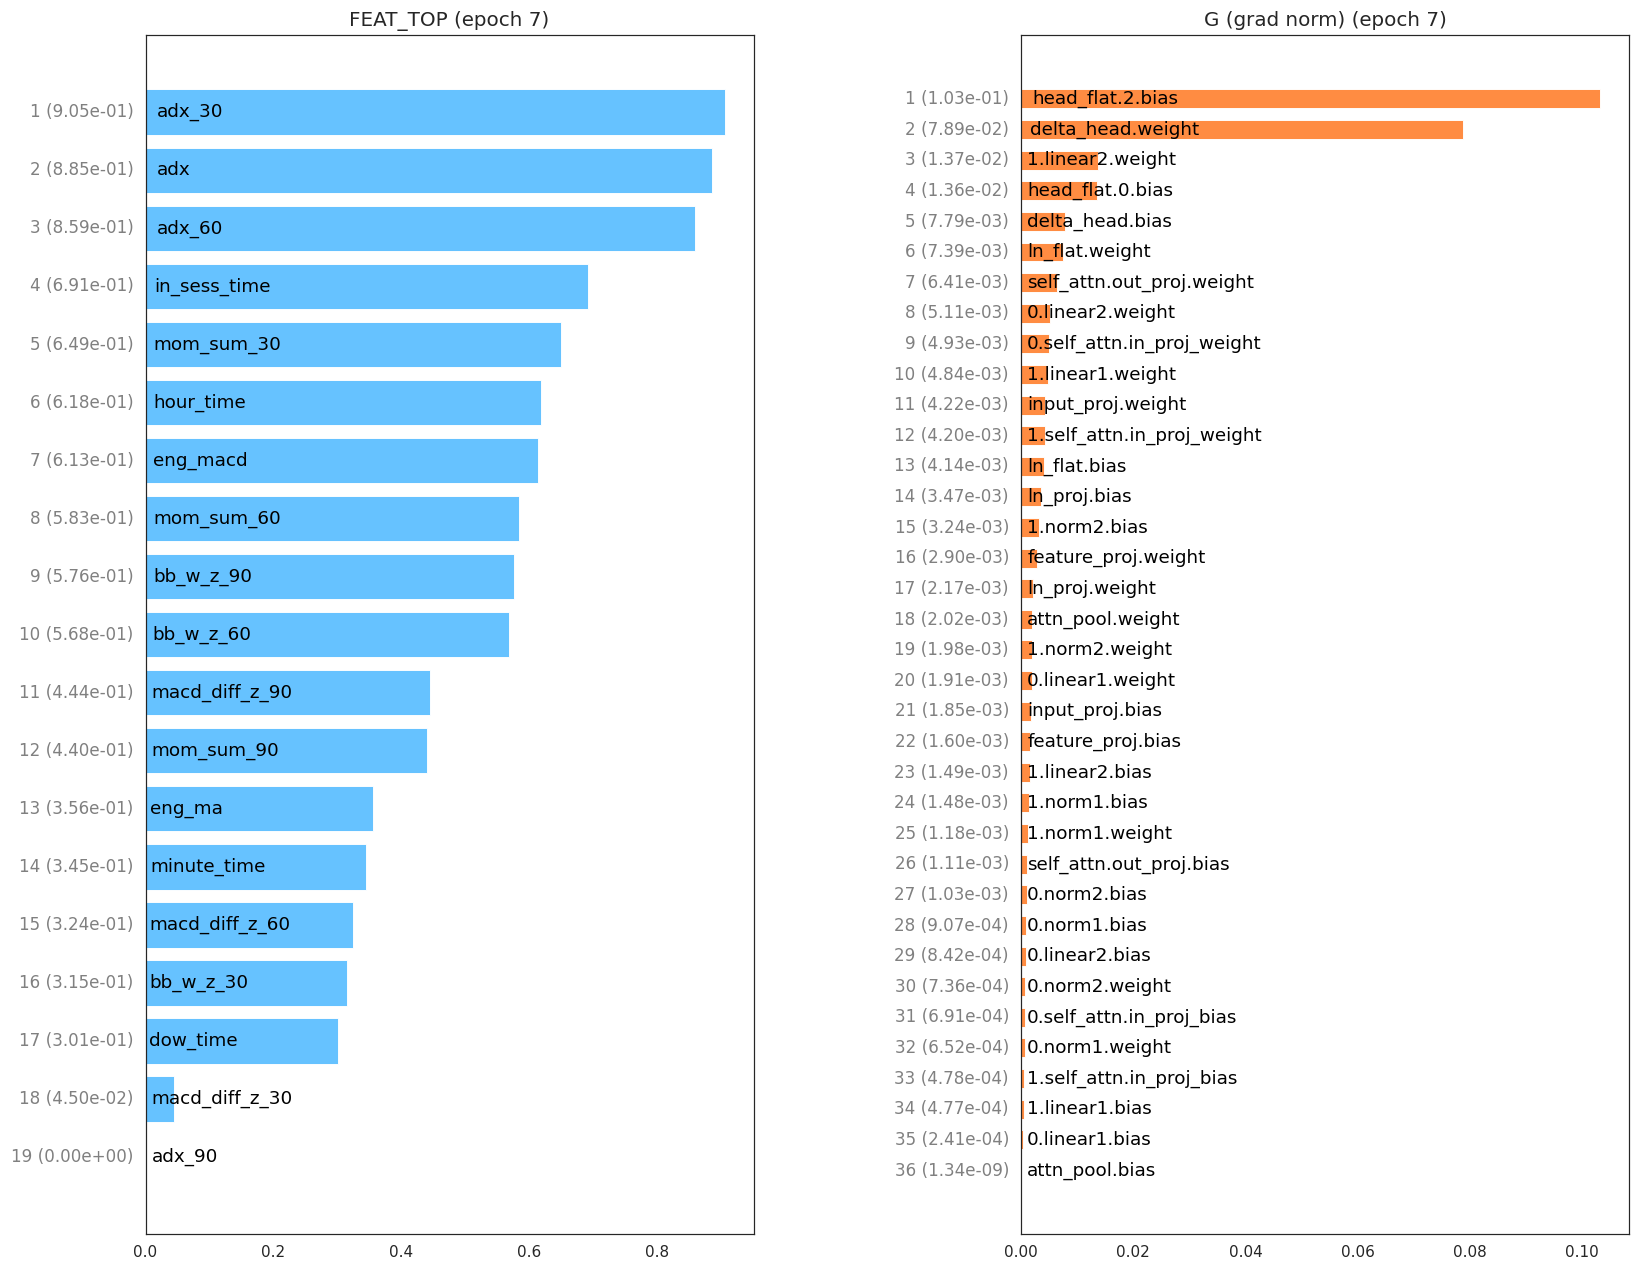

Epoch 01  TRAIN→ RMSE=0.10439, R²=-0.096 |  VALID→ RMSE=0.11417, R²=-0.086 |  lr=1.27e-04 |  loss=1.18635e-02 |  improved=True


Epoch 2 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 02  TRAIN→ RMSE=0.10188, R²=-0.044 |  VALID→ RMSE=0.11387, R²=-0.080 |  lr=2.05e-04 |  loss=1.12725e-02 |  improved=True


Epoch 3 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 03  TRAIN→ RMSE=0.10354, R²=-0.078 |  VALID→ RMSE=0.11595, R²=-0.120 |  lr=3.25e-04 |  loss=1.14672e-02 |  improved=False


Epoch 4 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 04  TRAIN→ RMSE=0.10378, R²=-0.083 |  VALID→ RMSE=0.11031, R²=-0.013 |  lr=4.72e-04 |  loss=1.13115e-02 |  improved=True


Epoch 5 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 05  TRAIN→ RMSE=0.10334, R²=-0.074 |  VALID→ RMSE=0.11064, R²=-0.020 |  lr=6.29e-04 |  loss=1.11012e-02 |  improved=False


Epoch 6 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 06  TRAIN→ RMSE=0.10357, R²=-0.078 |  VALID→ RMSE=0.10969, R²=-0.002 |  lr=7.75e-04 |  loss=1.10110e-02 |  improved=True


Epoch 7 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 07  TRAIN→ RMSE=0.10349, R²=-0.077 |  VALID→ RMSE=0.10969, R²=-0.002 |  lr=8.95e-04 |  loss=1.09811e-02 |  improved=False


Epoch 8 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
importlib.reload(params) #############
importlib.reload(models_custom) #############
importlib.reload(models_core) #############
importlib.reload(plots) #############

n_days = len(train_loader.dataset)
print(f"Training sees {n_days} unique trading days per epoch.\n")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: total={total_params:,}, trainable={trainable_params:,}\n")

print('Using HyperParameters:\n', params.hparams)

best_val_rmse  = models_custom.model_training_loop(
    model               = model,
    optimizer           = optimizer,
    scheduler           = scheduler,
    scaler              = GradScaler(),
    train_loader        = train_loader,
    val_loader          = val_loader
)